In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Import the impactor flux and energy data:

In [2]:
imp_flux_energy = pd.read_csv('../fluxes-2024-all_EDITED.csv')#.dropna(axis=1, how='all')

For each set of impactor energies and fluxes, plot as a separate series with a separate colour in matplotlib:

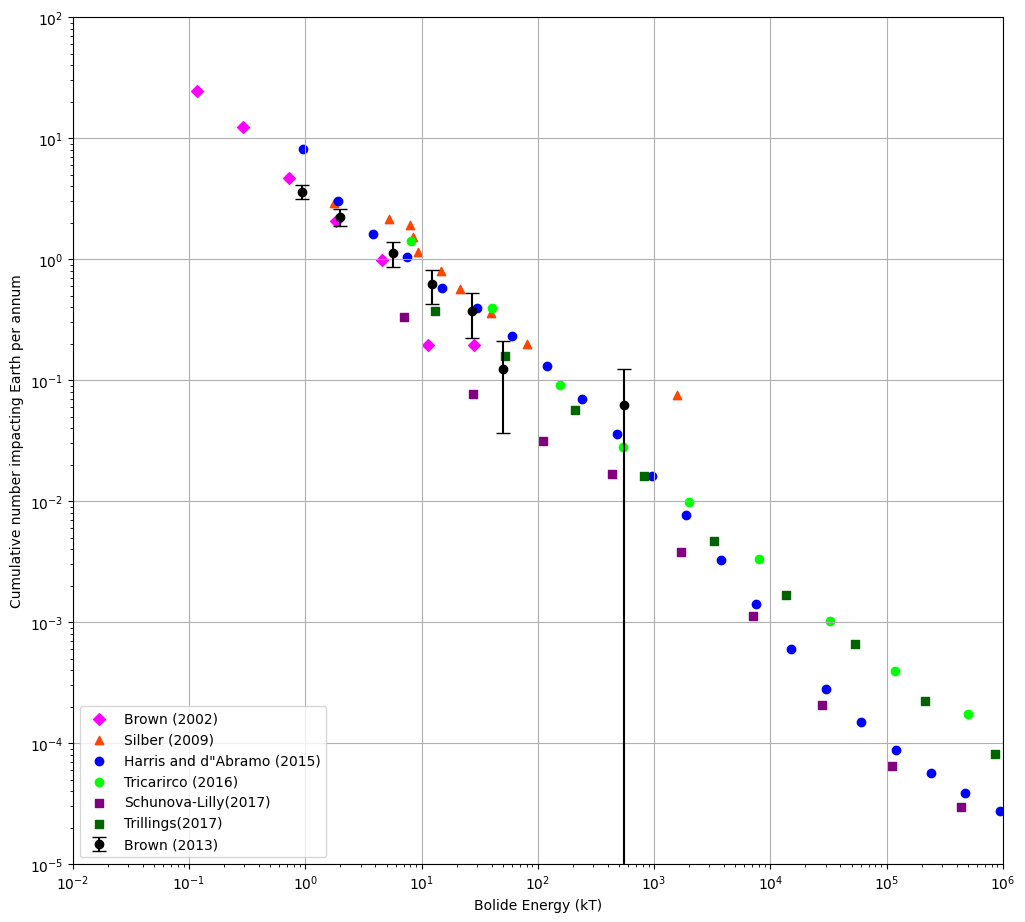

In [3]:
# get index of all the columns with energy
energy_indices = [imp_flux_energy.columns.get_loc(col) for col in imp_flux_energy.columns if 'Energy (kT)' in col]
# same colours/markers as in the original image
colours = ['fuchsia', 'orangered', 'black', 'blue', 'lime', 'purple', 'darkgreen']
markers = ['D', '^', 'o', 'o', 'o', 's', 's']

# plot figure
plt.figure(figsize = (12, 11))
for j, ind in enumerate(energy_indices):
    # plot energy in the energy index against the flux (impacts per year), in the following column, for each set of impactors
    # plot errorbars if given
    try:
        if 'err' in imp_flux_energy.columns[ind + 2]:
            plt.errorbar(imp_flux_energy.iloc[:,ind], imp_flux_energy.iloc[:, ind + 1], 
                         yerr = imp_flux_energy.iloc[:, ind + 2], label = imp_flux_energy.columns[ind + 1], 
                         fmt=markers[j], capsize=5, c=colours[j])#c=f'C{energy_indices.index(ind)}')
        else:
            plt.scatter(imp_flux_energy.iloc[:,ind], imp_flux_energy.iloc[:, ind + 1], 
                        label = imp_flux_energy.columns[ind + 1], c=colours[j], marker=markers[j])
    except: 
        # otherwise just normal scatter
        plt.scatter(imp_flux_energy.iloc[:,ind], imp_flux_energy.iloc[:, ind + 1], 
                    label = imp_flux_energy.columns[ind + 1], c=colours[j], marker=markers[j])
# log scale
plt.xscale('log'), plt.yscale('log')
# set xlim, ylim to same values used in figure
xmin, xmax = 1e-2, 1e6
ymin, ymax = 1e-5, 1e2
# x, ylim
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# label axes
plt.xlabel('Bolide Energy (kT)')
plt.ylabel('Cumulative number impacting Earth per annum')
# set x, y ticks
plt.xticks(ticks=np.geomspace(xmin, xmax, int(np.log10(xmax) - np.log10(xmin) + 1)), minor=False)
plt.yticks(ticks=np.geomspace(ymin, ymax, int(np.log10(ymax) - np.log10(ymin) + 1)), minor=False)
# show grid
plt.grid()
# legend
plt.legend(loc='lower left')